# V2 Kanye

## Clean Up

### CSV - Tweets

In [1]:
%pip install pandas

import pandas as pd
import re

# CSV laden
df_tweets = pd.read_csv("Input/KanyeTweets.csv")

# Spalte vereinheitlichen
df_tweets.rename(columns={"Tweet": "text"}, inplace=True)

# Nur echte Original-Tweets (kein RT, kein NaN)
df_tweets = df_tweets[df_tweets["text"].notna()]
df_tweets = df_tweets[~df_tweets["text"].str.startswith("RT")]
df_tweets["text"] = df_tweets["text"].astype(str)

# Links entfernen
df_tweets["text"] = df_tweets["text"].apply(lambda x: re.sub(r"http\S+", "", x))

# Bereinigung (Mentions, Emojis, Sonderzeichen)
def clean_tweet(text):
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"[^0-9A-Za-zäöüÄÖÜß.,!?\'\"\s]", "", text)
    return text.strip()

# Neue Spalte erzeugen
df_tweets["text"] = df_tweets["text"].apply(clean_tweet)

# Index zurücksetzen und nur 'text' behalten
df_tweets = df_tweets[["text"]].reset_index(drop=True)

# Ergebnis anzeigen
print(df_tweets.head())


Note: you may need to restart the kernel to use updated packages.
                                                text
0   Lets always remember this as my final tweet ye24
1  Lets break one last window before we get outa ...
2      Well everyone We had a nice run Jesus is King
3  Never turn our backs Demna and the Balenciaga ...
4  I stand by Balenciaga and denounce all witch h...


### CSV - Lyrics

In [2]:
import pandas as pd

# Lyrics einlesen
df_lyrics = pd.read_csv("Input/LyricsWest.csv")

# Nur gültige Texte behalten
df_lyrics = df_lyrics[df_lyrics["text"].notna()]
df_lyrics["text"] = df_lyrics["text"].astype(str)

# Alle nicht-leeren Zeilen sammeln
all_lines = []

for song in df_lyrics["text"]:
    lines = song.split("\n")
    for line in lines:
        line = line.strip()
        if line:  # leere Zeilen ignorieren, aber alles andere behalten (auch "[Chorus]" etc.)
            all_lines.append(line)

# Optional anzeigen
print(f"Anzahl Zeilen: {len(all_lines)}")
print("Beispiel:", all_lines[:5])


Anzahl Zeilen: 7136
Beispiel: ['[Produced by Kanye West and Jon Brion]', '[Intro: Jamie Foxx]', "She take my money when I'm in need", "Yeah, she's a triflin' friend indeed", "Oh, she's a gold digger"]


### PDF's - Biography & Psychoanalytics & Book

In [3]:
import glob
import tqdm
from PyPDF2 import PdfReader

def extract_pdf_text(pdf_path):
    with open(pdf_path, "rb") as f:
        reader = PdfReader(f)
        texts = [page.extract_text() for page in reader.pages if page.extract_text()]
    return " ".join(texts)

# PDFs laden
pdf_paths = [
    "Input/Biography.pdf",
    "Input/Study.pdf",
    "Input/TWAK.pdf"
]

# Inhalte bereinigen
def clean_pdf_text(text):
    text = re.sub(r"\s+", " ", text)  # überflüssige Leerzeichen
    text = re.sub(r"[^0-9A-Za-zäöüÄÖÜß.,!?\'\"\s\-–]", "", text)  # Sonderzeichen (behutsam)
    return text.strip()

# Bereinigte Texte in Dict
pdf_cleaned = {}
for path in tqdm.tqdm(pdf_paths):
    name = path.split("/")[-1].replace(".pdf", "")
    raw = extract_pdf_text(path)
    cleaned = clean_pdf_text(raw)
    pdf_cleaned[name] = cleaned


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


## Chunken

In [4]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=128,
    chunk_overlap=16,
    model_name="paraphrase-multilingual-MiniLM-L12-v2"
)


# 1. Tweets (bereinigt in df_tweets["text"])
tweets_text = "\n".join(df_tweets["text"])
tweet_chunks_token = [{"text": chunk, "source": "tweets"} for chunk in token_splitter.split_text(tweets_text)]

# 2. Lyrics
lyrics_text = "\n".join(all_lines)
lyrics_chunks_token = [{"text": chunk, "source": "lyrics"} for chunk in token_splitter.split_text(lyrics_text)]

# 3. Biografie
biography_text = pdf_cleaned.get("Biography", "")
biography_chunks_token = [{"text": chunk, "source": "biography"} for chunk in token_splitter.split_text(biography_text)]

# 4. Psychoanalytische Studie
study_text = pdf_cleaned.get("Study", "")
study_chunks_token = [{"text": chunk, "source": "study"} for chunk in token_splitter.split_text(study_text)]

# 5. TWAK-Zitatbuch
twak_text = pdf_cleaned.get("TWAK", "")
twak_chunks_token = [{"text": chunk, "source": "twak"} for chunk in token_splitter.split_text(twak_text)]


### Zusammenführen

In [5]:
# Alle Quellen-Chunks in einer Liste zusammenführen
all_chunks = (
    tweet_chunks_token +
    lyrics_chunks_token +
    biography_chunks_token +
    study_chunks_token +
    twak_chunks_token
)

# Optional: kleine Übersicht
print(f"Gesamtanzahl Chunks: {len(all_chunks)}")
print("Beispiel-Chunk:", all_chunks[0])


Gesamtanzahl Chunks: 1421
Beispiel-Chunk: {'text': 'Lets always remember this as my final tweet ye24 Lets break one last window before we get outa here I caught this guy with Kim Good night Well everyone We had a nice run Jesus is King Never turn our backs Demna and the Balenciaga family for life Cancel cancel culture Jesus please heal I stand by Balenciaga and denounce all witch hunts and I cancel cancel culture Jesus is King Ending trafficking doesnt start or end with a fashion campaign for Christ Sake Hes done miracles on me The use of Porn destroyed my family but Jesus will heal everythin Remove any and all', 'source': 'tweets'}


## Embedding

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
texts = [chunk["text"] for chunk in all_chunks]
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)


Batches:   0%|          | 0/45 [00:00<?, ?it/s]

## FAISS

In [7]:
import os
import pickle
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)
print("FAISS Index enthält:", index.ntotal, "Vektoren")


os.makedirs("faiss", exist_ok=True)
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(all_chunks, f)
print("FAISS Index & Chunk-Mapping gespeichert unter 'faiss/'")

FAISS Index enthält: 1421 Vektoren
FAISS Index & Chunk-Mapping gespeichert unter 'faiss/'


## Retrieve

In [8]:
def retrieve(query, k=20):
    """
    Retrieve the top k similar Kanye text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [all_chunks[i]["text"] for i in indices[0]]
    retrieved_embeddings = [model.encode(all_chunks[i]["text"], convert_to_numpy=True) for i in indices[0]]
    return retrieved_texts, retrieved_embeddings, distances[0]

query = "What does Kanye say about his Daughter North?"
results, result_embeddings, distances = retrieve(query, k=10)
print("Retrieved document preview:")
print(results[0][:300])


Retrieved document preview:
[Verse 1: Kanye West] I met this girl when I was three years old And what I loved most, she had so much soul She said, "Excuse me, lil homie, I know you don't know me But my name is Windy and I like to blow trees." And from that point I never blow her off Niggas come from out of town, I like to show


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


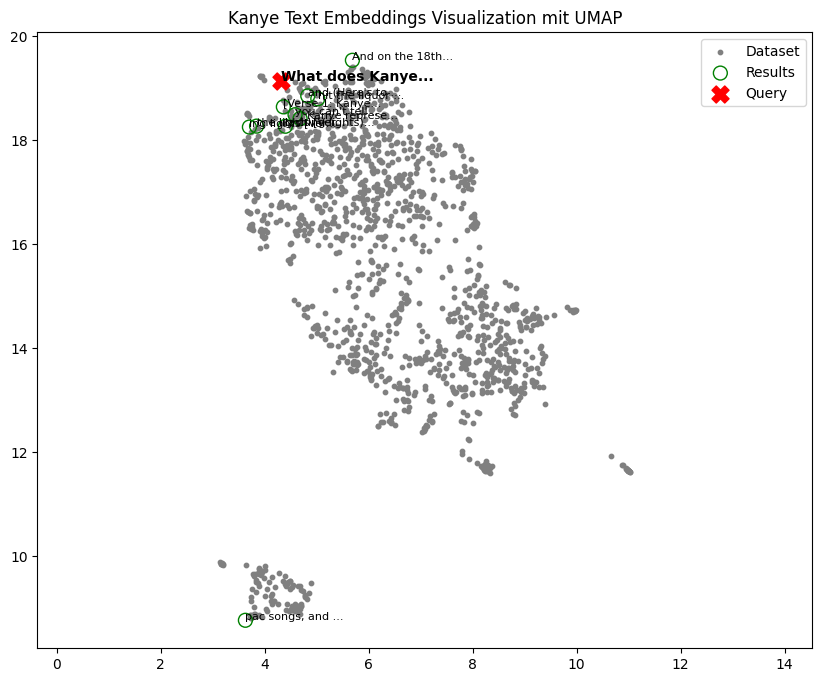


 Query: What does Kanye say about his Daughter North?

[1] Ähnlichkeitsabstand: 18.0234
Text:
[Verse 1: Kanye West] I met this girl when I was three years old And what I loved most, she had so much soul She said, "Excuse me, lil homie, I know you don't know me But my name is Windy and I like to blow trees." And from that point I never blow her off Niggas come from out of town, I like to show
------------------------------------------------------------
[2] Ähnlichkeitsabstand: 18.2353
Text:
pac songs, and speculated that association of the rapper to her brother allowed her to understand and appreciate his songs more. Now older, she found aspects of Kanye West's music resonating with her in similar ways to Tupac's. More specifically, she experi - enced West's contradictory persona, rife
------------------------------------------------------------
[3] Ähnlichkeitsabstand: 18.3127
Text:
, Kanye represents the voice inside us that pushes us to go beyond.FOREWORD FOREWORD If anyones reading

In [9]:
import umap
import matplotlib.pyplot as plt
import numpy as np

def shorten_text(text, max_length=15):
    return (text[:max_length] + '...') if len(text) > max_length else text

# 1. Fit UMAP auf alle Embeddings (nur einmal, wenn noch nicht geschehen)
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
projected_dataset_embeddings = reducer.fit_transform(embeddings)  # embeddings = alle Chunks

# 2. Transformiere die Retrieval-Ergebnisse (retrieved embeddings)
projected_result_embeddings = reducer.transform(np.array(result_embeddings))

# 3. Transformiere Query-Embedding
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = reducer.transform(query_embedding)

# 4. Plot
plt.figure(figsize=(10,8))

plt.scatter(projected_dataset_embeddings[:,0], projected_dataset_embeddings[:,1],
            s=10, color='gray', label='Dataset')

plt.scatter(projected_result_embeddings[:,0], projected_result_embeddings[:,1],
            s=100, facecolors='none', edgecolors='green', label='Results')

plt.scatter(project_original_query[:,0], project_original_query[:,1],
            s=150, marker='X', color='red', label='Query')

# Beschriftungen der Resultate
for i, text in enumerate(results):
    plt.annotate(shorten_text(text), 
                 (projected_result_embeddings[i,0], projected_result_embeddings[i,1]),
                 fontsize=8)

# Beschriftung der Query
plt.annotate(shorten_text(query), 
             (project_original_query[0,0], project_original_query[0,1]),
             fontsize=10, fontweight='bold')

plt.gca().set_aspect('equal', 'datalim')
plt.title('Kanye Text Embeddings Visualization mit UMAP')
plt.legend()
plt.show()

print(f"\n Query: {query}\n")

for i, (text, dist) in enumerate(zip(results, distances)):
    print(f"[{i+1}] Ähnlichkeitsabstand: {dist:.4f}")
    print(f"Text:\n{text[:300]}")  # max 300 Zeichen
    print("-" * 60)


## Groq


In [10]:
def build_prompt(context_chunks, user_query):
    context_block = "\n\n".join(context_chunks)
    prompt = f"""Beantworte folgende Frage basierend auf dem gegebenen Kontext.
 
Kontext:
{context_block}
 
Frage:
{user_query}
 
Antwort:"""
    return prompt

In [11]:
# 1. Lade API Key
from dotenv import load_dotenv
import os
from groq import Groq

# Lade .env Datei aus dem Unterordner "env"
load_dotenv(dotenv_path="env/.env")

# Hole den API Key
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key is None:
    raise ValueError("API Key not found! Please check your env/.env file.")

# Initialisiere Groq-Client
client = Groq(api_key=groq_api_key)

# 2. Liste möglicher User Queries zur Bachelorarbeit
user_queries = [
    "Was sind Kanyes Hauptthemen in seinen Liedern?",
    "Wie beschreibt Kanye West seine Beziehung zu seiner Tochter?",
    "Welche Rolle spielt Religion in Kanyes Musik?",
    "Wie äußert sich Kanye zu Mode und seinem Einfluss darauf?",
    "Was sagt Kanye über seine Karriere im Musikbusiness?",
    "Welche Aussagen macht Kanye über seine Mental Health?",
    "Wie beschreibt Kanye seine künstlerische Vision?",
    "Was sind Kanyes Gedanken zur amerikanischen Gesellschaft?",
    "Wie spricht Kanye über seine Familie und Freunde?",
    "Was sind Kanyes Ansichten zur Freiheit und Kreativität?"
]


# 3. Für jede Query: retrieve, prompt bauen, Anfrage an Groq, Ausgabe
for user_query in user_queries:
    print(f"\n Frage: {user_query}")

    # 3. Retrieve similar chunks
    retrieved_chunks, _, _ = retrieve(user_query, k=3)

    # 4. Build prompt
    prompt = build_prompt(retrieved_chunks, user_query)

    # 5. Groq Request
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "Du bist ein hilfsbereiter wissenschaftlicher Assistent."},
            {"role": "user", "content": prompt}
        ]
    )

    # 6. Ausgabe
    print(response.choices[0].message.content)


 Frage: Was sind Kanyes Hauptthemen in seinen Liedern?
Basierend auf dem gegebenen Kontext, insbesondere dem Inhalt des Buches "The World According to Kanye" und dem Song-Auszug, können Kanyes Hauptthemen in seinen Liedern wie folgt identifiziert werden:

1. Selbstwertgefühl (Self Esteem) - wie im Titel des Kapitels "Kanye on Self Esteem" und im Song-Auszug, wo er sich selbst als Künstler und Visionär präsentiert.
2. Kunst und Kreativität (Art and Creativity) - wie im Kapitel "Kanye on Art" und im Song-Auszug, wo er über die Bedeutung von Proportionen und Farbe spricht.
3. Musik und Hip-Hop (Music and Hip-Hop) - wie im Kapitel "Kanye on Music" und "Kanye on Hip-Hop", wo er seine Musik und seine Rolle in der Musikindustrie reflektiert.
4. Liebe und Beziehungen (Love) - wie im Kapitel "Kanye on Love", wo er seine Gefühle und Beziehungen thematisiert.
5. Erfolg und Reichtum (Success and Wealth) - wie im Song-Auszug, wo er über seine Erfolge und seinen Reichtum spricht (z.B. "250 Million.

## Testing